<a href="https://colab.research.google.com/github/dgsmith1988/ECSE-552-Final-Project/blob/main/librosa_library_testing/librosa_library_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Important: since Graham's google drive folder ECSE-552-FP is shared, it will not appear on MyDrive by default,
# therefore, before running this notebook, you should right click in this shared folder and click on Add to MyDrive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

In [4]:
"""
Gets a melspectrogram using librosa libraty

Args:

    file_path: file of .wav file to process
    sr: sample rate to load the audio. If none is specified, librosa will utilise native 44.1kHz
    n_fft: how many samples are to be utilised per fft window
    hop_length: number of samples not analysed between consecutive fft windows
    n_mels: number of bins in which the spectogram is to be divided in the y-axis
    fmin, fmax: minimum and maximum frequencies to be considered in the specogram (Hz)
    top_db: highest intensity in db
    max_t: length of time to which the audio will be cropped.
    
Returns:
    spec_db: mel spectogram in db in the form of a np array.
    sr: sampling rate utilized.
"""


def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300,
                          top_db=80, max_t=5):
    wav, sr = librosa.load(file_path, sr=sr)
    if wav.shape[0] < max_t * sr:
        wav = np.pad(wav, int(np.ceil((max_t * sr - wav.shape[0]) / 2)), mode='reflect')
    else:
        wav = wav[:max_t * sr]
    spec = librosa.feature.melspectrogram(y= wav, sr=sr, n_fft=n_fft,
                                          hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    spec_db = librosa.power_to_db(spec, top_db=top_db)
    return spec_db, sr

In [5]:
"""
Displays several spectograms 
Args:
    spec_db: list of one or more spectograms (np.arrays of dimension 2) to be displayed( only the first six will be 
    shown)
    sr: sampling rate or rates, depending on how many spectogram are considered in spec_db
    labels: labels to  be utilized in the same order as they are provided to annotate each spectogram.
"""
def display_spectogram(spec_db, sr, labels=None):
    ncols, nrows = 3, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 9))
    n_display = min(ncols * nrows, len(spec_db))
    for i in range(n_display):
        col_idx = int(i / ncols)
        row_idx = int(i % ncols)
        img = librosa.display.specshow(spec_db[i], x_axis='time',
                                       y_axis='mel', sr=sr[i],
                                       fmax=8000, ax=axs[col_idx][row_idx])
        axs[col_idx][row_idx].set_title(labels[i])
    fig.colorbar(img, ax = axs[0][2],  format='%+2.0f dB')
    # ax.set(title='Mel-frequency spectogram')
    plt.tight_layout()
    plt.show()

In [11]:
"""
AudioDataset class is a child of pytorch's Dataset
"""
class AudioDataset(Dataset):
    """
    Creates an AudioDataset

    Args:
        root_dir: directory where the audio files are to be read from the
                  this directory is expected to be composed of several subdirectories, one per language
                  each subdirectory will be scanned for wav files and each of the files will be added to the dataset.
                  files from the same subdirectory will have the same ordinal label.
    """
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        self.sr = []
        self.labels = []
        self.dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for d in self.dirs:
          print(f'Reading from folder {d}')
          walk_dir = os.path.join(root_dir, d)
          # find recursively all files inside dir (including those that are in subdirs)
          for root, subdirs, files in tqdm(os.walk(walk_dir)):
              for filename in files:
                  file_path = os.path.join(root, filename)
                  if filename.endswith('wav'):
                      spec, sr = get_melspectrogram_db(file_path)
                      # img = spec_to_image(spec)[np.newaxis,...]
                      self.data.append(spec)
                      self.labels.append(self.dirs.index(d))
                      self.sr.append(sr)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Reading from folder ES


7it [00:00, 15.49it/s]


Reading from folder EN


7it [00:00, 16.79it/s]


Reading from folder DE


7it [00:00, 16.35it/s]


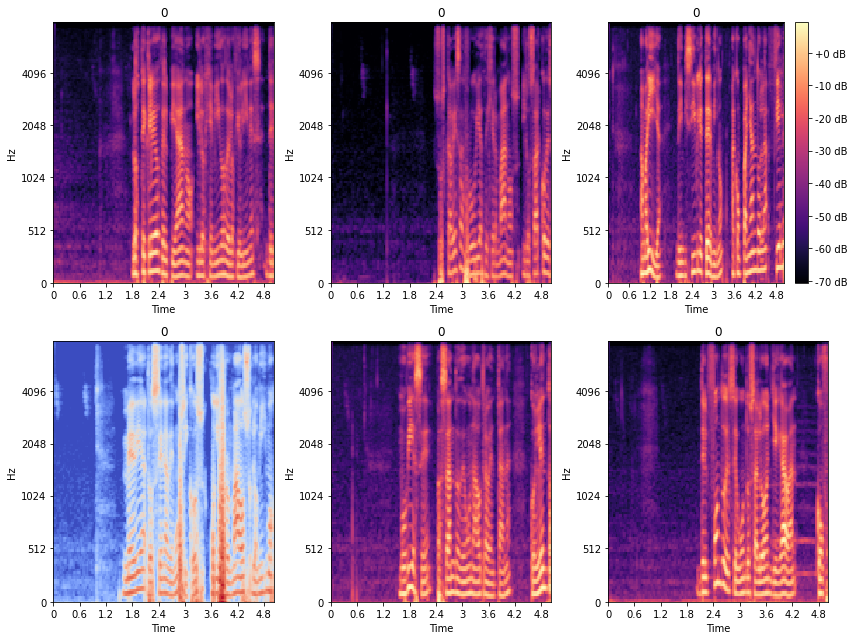

In [12]:
data_folder_name = 'gdrive/MyDrive/ECSE-552-FP/Data/Data_lang'
dataset = AudioDataset(data_folder_name)
display_spectogram(list(dataset[:][0]), list(dataset.sr[:]), list(dataset[:][1]))